In [15]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
from qnm_visualisation import qnm_viz
from matplotlib.animation import FuncAnimation

In [6]:

# TO DO: import data properly 
sim = qnmfits.SXS(ID=305, zero_time=(2,2))

/data/rvnd2/python_envs/python-3.11-clone/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


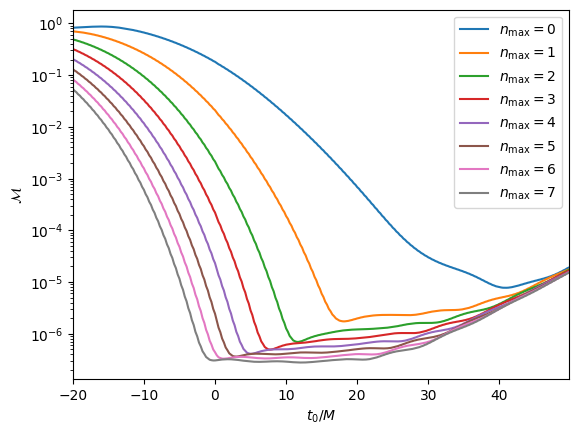

In [7]:
t0_vals = np.arange(-20, 50, 0.25)
max_n_max = 7

MM = {}
for n_max in np.arange(0, max_n_max+1):
    
    MM[n_max] = np.zeros_like(t0_vals)
    for i, t0 in enumerate(t0_vals):

        modes = [(2,2,n,1) for n in np.arange(0, n_max+1)]

        best_fit = qnmfits.ringdown_fit(
            sim.times, 
            sim.h[2,2], 
            modes=modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0
        )
    
        MM[n_max][i] = best_fit['mismatch']

for n_max in np.arange(0, max_n_max+1):
    plt.plot(t0_vals, MM[n_max], label=r'$n_{\mathrm{max}}='+str(n_max)+'$')
plt.semilogy()
plt.xlim(min(t0_vals), max(t0_vals))
plt.xlabel(r'$t_0/M$')
plt.ylabel(r'$\mathcal{M}$')
plt.legend()
plt.show()

In [17]:
l_max = 6
n_max = 7
t0 = {0:40., 1:18.5, 2:12., 3:8., 4:5.5, 5:3., 6:1.5, 7:0.}[n_max]
qnm_viz = qnm_viz(sim, l_max=l_max)

In [7]:
mapping = (2,2,0,1)

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

best_fit_linear = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_mode=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

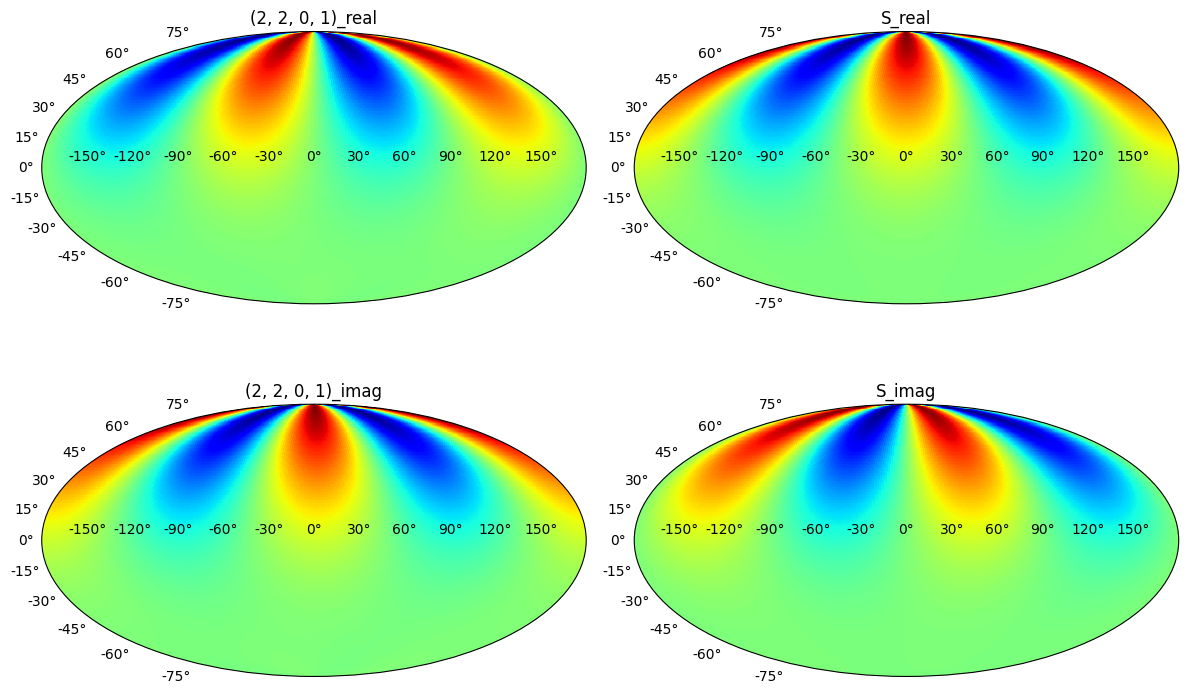

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, 
                        subplot_kw={'projection': 'mollweide'}, 
                        figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

Lon, Lat = np.meshgrid(lon, lat)
F = mode_mapping(np.pi/2-Lat, Lon, best_fit_linear, mapping, l_max)
G = spheroidal(np.pi/2-Lat, Lon, mapping, l_max, sim.chif_mag)

axs[0,0].title.set_text(str(mapping)+'_real')
axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

axs[1,0].title.set_text(str(mapping)+'_imag')
axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

axs[0,1].title.set_text('S_real')
axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

axs[1,1].title.set_text('S_imag')
axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

#### Animation 

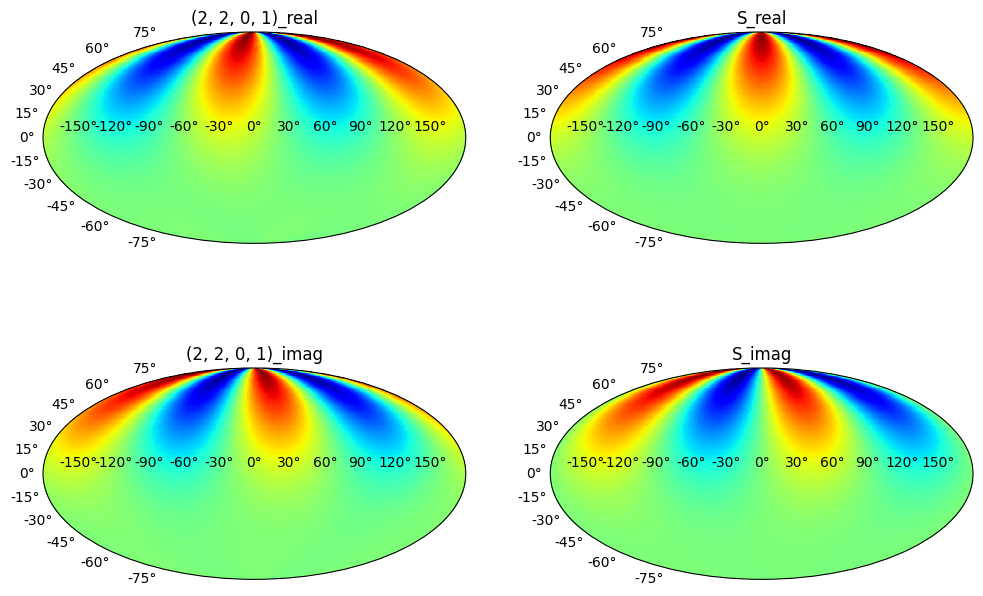

In [11]:
mapping = (2,2,0,1)

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

fig, axs = plt.subplots(nrows=2, ncols=2, 
                    subplot_kw={'projection': 'mollweide'}, 
                    figsize=(12,8))

def update(t):

    best_fit_linear = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                            sim.h, 
                                            modes=QNMs.copy(),
                                            Mf=sim.Mf,
                                            chif=sim.chif_mag,
                                            t0=t,
                                            mapping_mode=mapping,
                                            spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                                for m in np.arange(-l,l+1)])

    F = mode_mapping(np.pi/2-Lat, Lon, best_fit_linear, mapping, l_max)
    G = spheroidal(np.pi/2-Lat, Lon, mapping, l_max, sim.chif_mag)

    axs[0,0].title.set_text(str(mapping)+'_real')
    axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

    axs[1,0].title.set_text(str(mapping)+'_imag')
    axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

    axs[0,1].title.set_text('S_real')
    axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

    axs[1,1].title.set_text('S_imag')
    axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

    return fig 


min_t0 = -10
max_t0 = 20
step_t0 = 1

ani = FuncAnimation(fig, update, frames=range(min_t0, max_t0, step_t0), interval=1)

ani.save('mapping_animation.mp4', writer='ffmpeg')

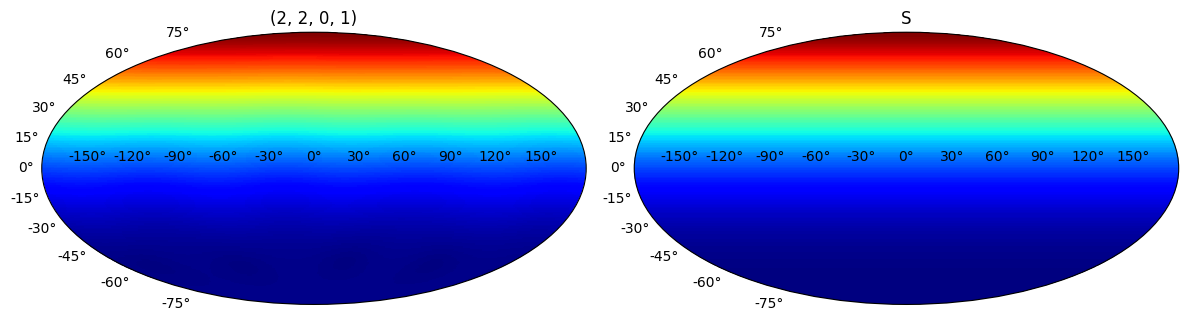

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, 
                        subplot_kw={'projection': 'mollweide'}, 
                        figsize=(12,5))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

Lon, Lat = np.meshgrid(lon, lat)
F = mode_mapping(np.pi/2-Lat, Lon, best_fit, mapping, l_max)
G = spheroidal(np.pi/2-Lat, Lon, mapping, l_max, sim.chif_mag)

axs[0].title.set_text(str(mapping))
axs[0].pcolormesh(Lon, Lat, np.abs(F), cmap=plt.cm.jet)

axs[1].title.set_text('S')
axs[1].pcolormesh(Lon, Lat, np.abs(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

In [ ]:
t0_vals = np.arange(-20, 50, 1)

mapping_modes = [(2,2,0,1), (2,2,1,1), (2,2,2,1), (2,2,5,1), 
                 (2,1,0,1), 
                 (3,3,0,1), (3,2,0,1),
                 (4,4,0,1)]

num_points = 300

with Pool(3) as p:
    result = list(p.map(my_function, 
                       [(mapping, sim, t0_vals, l_max, n_max, num_points) 
                        for mapping in mapping_modes]))

In [ ]:
extra = my_function(((2,2,0,-1), sim, t0_vals, l_max, n_max, num_points))

In [ ]:
for i, mapping_mode in enumerate(mapping_modes):
    plt.plot(t0_vals, result[i], label=mapping_mode)
plt.plot(t0_vals, extra, color='k', lw=1, ls=':', label=str((2,2,0,-1))
plt.semilogy()
plt.xlim(min(t0_vals), max(t0_vals))
plt.xlabel(r'$t_0/M$')
plt.ylabel(r'$\mathcal{M}$')
plt.legend()
plt.savefig('mapping.pdf')
plt.clf()
#plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
str((2,2,0,1))
str((2,2,0,-1))

'(2, 2, 0, -1)'

# Quadratic Test

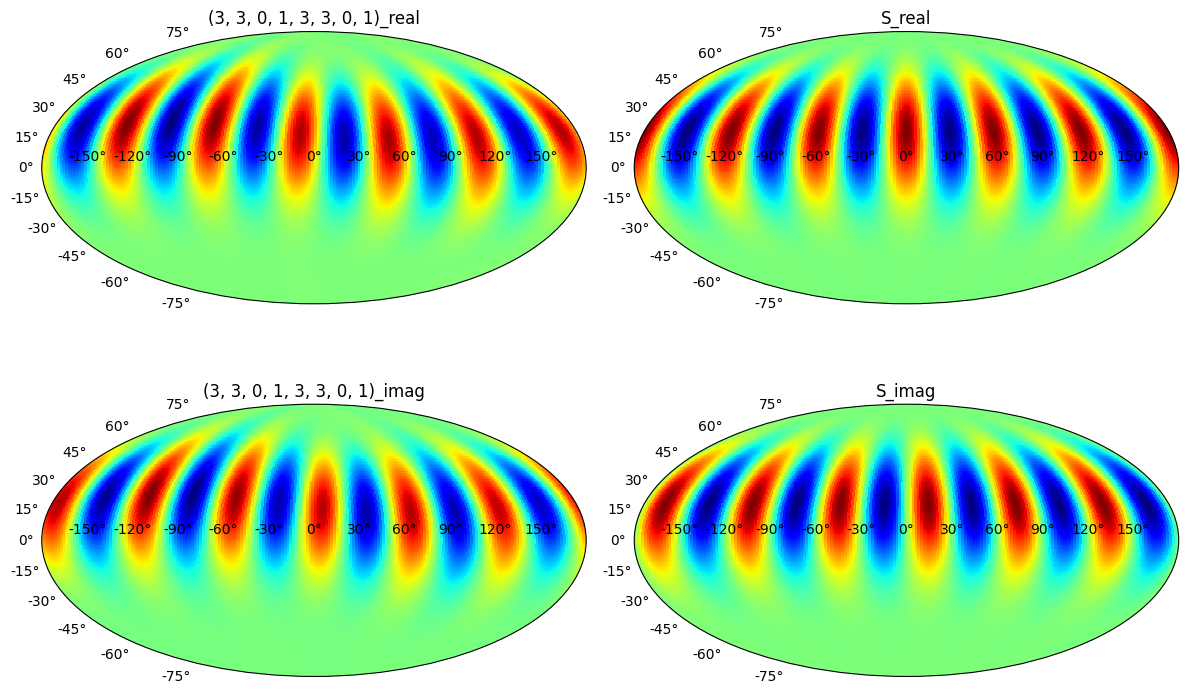

In [21]:
mapping = (2,2,0,1,2,2,0,1)

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)] + [mapping] 

best_fit_quad = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_mode=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)
Lon, Lat = np.meshgrid(lon, lat)

md_mapping = mode_mapping(np.pi/2-Lat, Lon, best_fit_quad, mapping, l_max)
expected = spheroidal(np.pi/2-Lat, Lon, mapping, l_max, sim.chif_mag)

qnm_viz.plot_mapping_projection(mapping, md_mapping, expected)

plt.tight_layout()
plt.show()

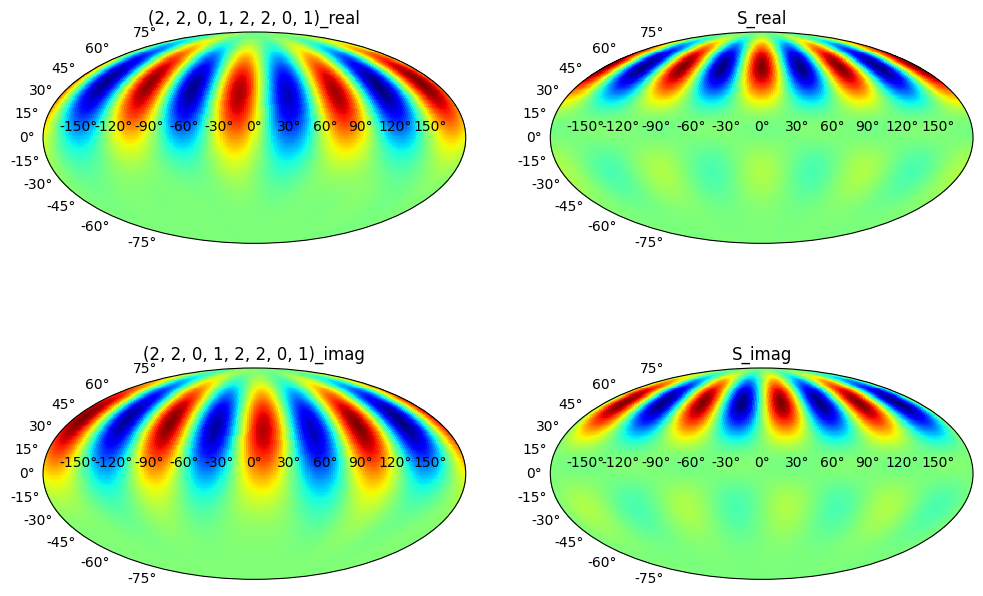

In [12]:
mapping = (2,2,0,1,2,2,0,1)

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)] + [mapping]

fig, axs = plt.subplots(nrows=2, ncols=2, 
                    subplot_kw={'projection': 'mollweide'}, 
                    figsize=(12,8))

def update(t):

    best_fit_quad = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                            sim.h, 
                                            modes=QNMs.copy(),
                                            Mf=sim.Mf,
                                            chif=sim.chif_mag,
                                            t0=t,
                                            mapping_mode=mapping,
                                            spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                                for m in np.arange(-l,l+1)])

    F = mode_mapping(np.pi/2-Lat, Lon, best_fit_quad, mapping, l_max)
    G = spheroidal(np.pi/2-Lat, Lon, mapping, l_max, sim.chif_mag)

    axs[0,0].title.set_text(str(mapping)+'_real')
    axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

    axs[1,0].title.set_text(str(mapping)+'_imag')
    axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

    axs[0,1].title.set_text('S_real')
    axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

    axs[1,1].title.set_text('S_imag')
    axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

    return fig 


min_t0 = -10
max_t0 = 20
step_t0 = 1

ani = FuncAnimation(fig, update, frames=range(min_t0, max_t0, step_t0), interval=1)

ani.save('mapping_animation_q.mp4', writer='ffmpeg')